Images downloaded from public sources
    
Be sure to set the requirements

### 1. Importing libraries

In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import os
import shutil
import pywt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn
import joblib
import json

### 2. Preprocessing

#### Detect face and eyes on the image

In [2]:
img = cv2.imread('./test_images/i (5).webp')
img.shape

(320, 320, 3)

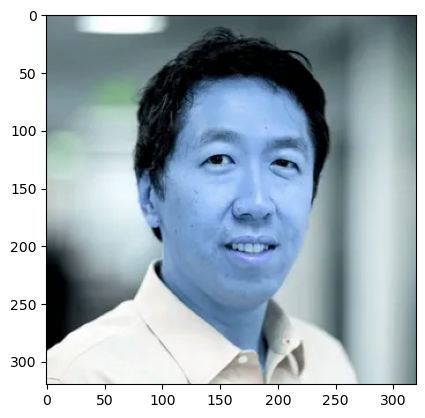

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(320, 320)

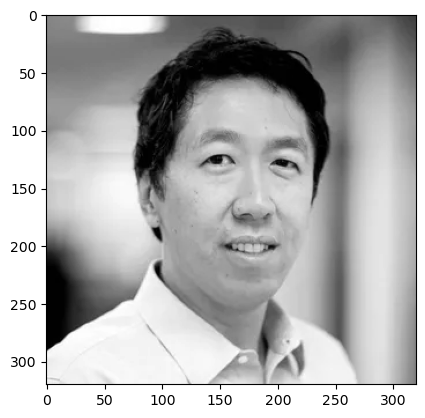

In [5]:
plt.imshow(gray, cmap='gray')

In [6]:
face_cascade = cv2.CascadeClassifier('.\opencv\haarcascades\haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('.\opencv\haarcascades\haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 92,  61, 170, 170]])

In [7]:
x,y,w,h = faces[0]

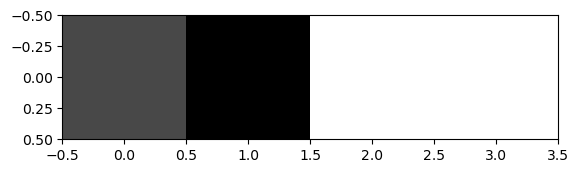

In [8]:
plt.imshow(faces, cmap='gray')

In [9]:
x,y,w,h

(92, 61, 170, 170)

#### Crop the facial region of the image

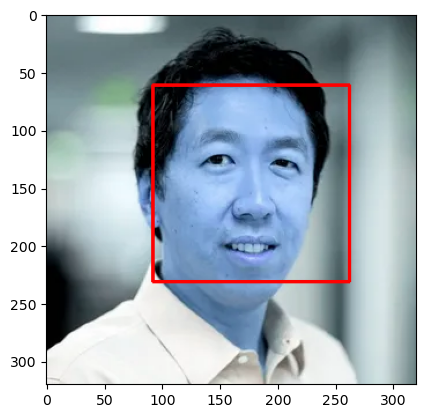

In [10]:
face_img = cv2.rectangle(img,(x,y), (x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

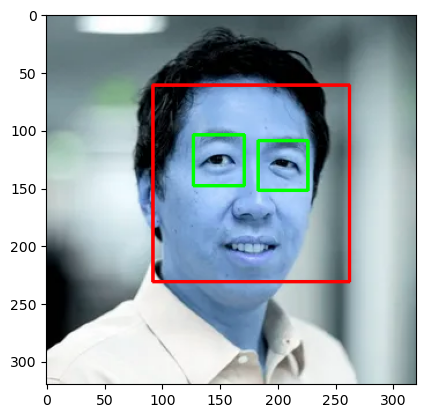

In [11]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew, eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)


plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

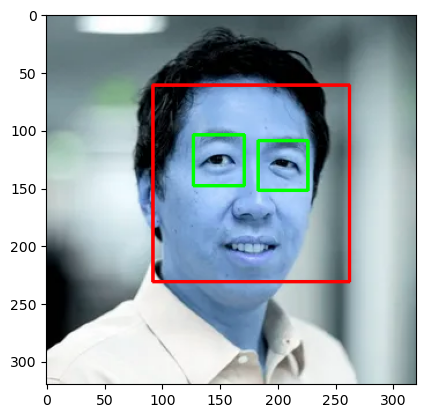

In [12]:
plt.imshow(face_img, cmap='gray')

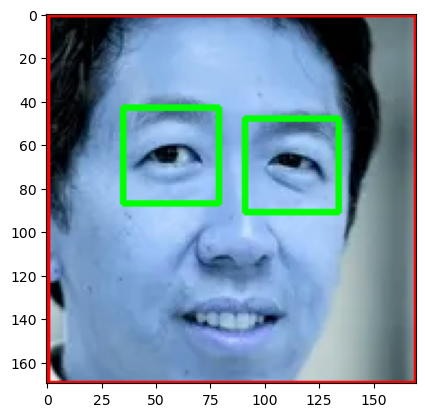

In [13]:
plt.imshow(roi_color, cmap='gray')

In [14]:
face_img.shape

(320, 320, 3)

In [15]:
roi_color.shape

(170, 170, 3)

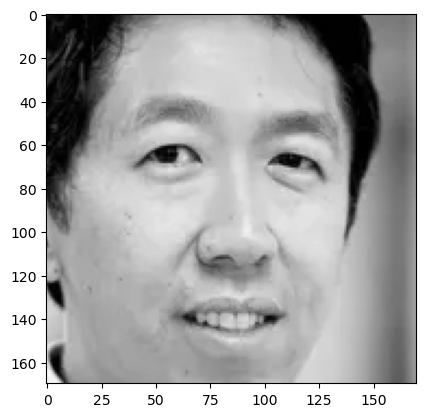

In [16]:
plt.imshow(roi_gray, cmap='gray')

#### Detect the face, if eye >=2
If it's less than >=2: ignore this image and we will not use such image for model training

In [17]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [18]:
path_to_data = './dataset/'
path_to_cr_data = './dataset/cropped/'

In [19]:
img_dirs = []
for i in os.scandir(path_to_data):
    if i.is_dir() and not 'cropped' in i.path:
        img_dirs.append(i.path)

In [20]:
img_dirs

['./dataset/Andrew_Ng',
 './dataset/Elon_Mask',
 './dataset/Fei-Fei_Li',
 './dataset/Geoffrey_Hinton',
 './dataset/Ilya_Sutskever']

In [21]:
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

#### Crop the face area for each image
There will be cropped folder inside dataset folder after you run this code

In [22]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for i in img_dirs:
    count = 1
    celebrity_name = i.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for j in os.scandir(i):
        roi_color = get_cropped_image_if_2_eyes(j.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print('Generating cropped images in folder: ',cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + '.png'
            cropped_file_path = cropped_folder + '/' + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

print('\nGenerating cropped images completed')

Andrew_Ng
Generating cropped images in folder:  ./dataset/cropped/Andrew_Ng
Elon_Mask
Generating cropped images in folder:  ./dataset/cropped/Elon_Mask
Fei-Fei_Li
Generating cropped images in folder:  ./dataset/cropped/Fei-Fei_Li
Geoffrey_Hinton
Generating cropped images in folder:  ./dataset/cropped/Geoffrey_Hinton
Ilya_Sutskever
Generating cropped images in folder:  ./dataset/cropped/Ilya_Sutskever

Generating cropped images completed


In [23]:
cropped_image_dirs

['./dataset/cropped/Andrew_Ng',
 './dataset/cropped/Elon_Mask',
 './dataset/cropped/Fei-Fei_Li',
 './dataset/cropped/Geoffrey_Hinton',
 './dataset/cropped/Ilya_Sutskever']

#### Manually examine cropped folder and delete any unwanted images

In [24]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list

#### Use wavelet transform
To create clues about different facial features like eyes, nose, lips, etc.

In [25]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor(imArray,cv2.COLOR_RGB2GRAY)
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [26]:
cropped_image = cv2.imread('./dataset/cropped/Andrew_Ng/Andrew_Ng1.png')

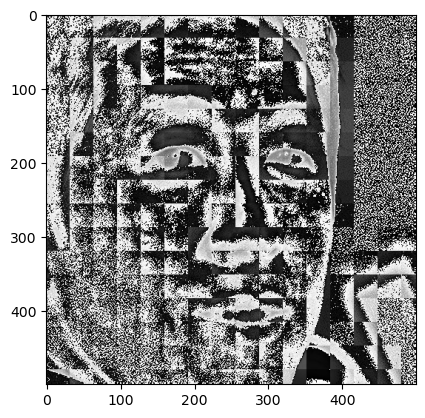

In [27]:
im_har = w2d(cropped_image, 'db1', 5)
plt.imshow(im_har, cmap='gray')

In [28]:
class_dict = {}
count = 0
for i in celebrity_file_names_dict.keys():
    class_dict[i] = count
    count += 1
class_dict

{'Andrew_Ng': 0,
 'Elon_Mask': 1,
 'Fei-Fei_Li': 2,
 'Geoffrey_Hinton': 3,
 'Ilya_Sutskever': 4}

In [29]:
X, y = [], []

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for i in training_files:
        img = cv2.imread(i)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32,32))
        img_har = w2d(img, 'db1', 5)
        scalled_img_har = cv2.resize(img_har, (32,32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1), scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [30]:
32*32*3 + 32*32

4096

In [31]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

(156, 4096)

In [32]:
X[0]

array([  1.,   4.,   1., ...,  21., 169.,  61.])

### 3. Build a Model

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [34]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C= 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8125

In [35]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.75      0.90      0.82        10
           2       0.60      0.75      0.67         4
           3       0.89      1.00      0.94         8
           4       1.00      0.25      0.40         4

    accuracy                           0.81        32
   macro avg       0.85      0.75      0.75        32
weighted avg       0.84      0.81      0.79        32



#### Using GridSearch we find the best model with the best parameters

In [36]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,3,5,10,100],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,3,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,3,5,10]
        }
    }
}

In [37]:
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.790667,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.621000,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.838667,{'logisticregression__C': 3}


In [38]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=3, solver='liblinear'))])}

In [39]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.71875

In [40]:
best_estimators['svm'].score(X_test, y_test)

0.8125

In [41]:
best_estimators['random_forest'].score(X_test, y_test)

0.65625

In [42]:
best_estimators['logistic_regression'].score(X_test, y_test)

0.90625

#### Conclusion
I have had logistic regression work best for correctly identifying the person in the image

In [43]:
best_clf = best_estimators['logistic_regression']

In [44]:
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[6, 0, 0, 0, 0],
       [0, 7, 1, 1, 1],
       [0, 0, 4, 0, 0],
       [0, 0, 0, 8, 0],
       [0, 0, 0, 0, 4]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

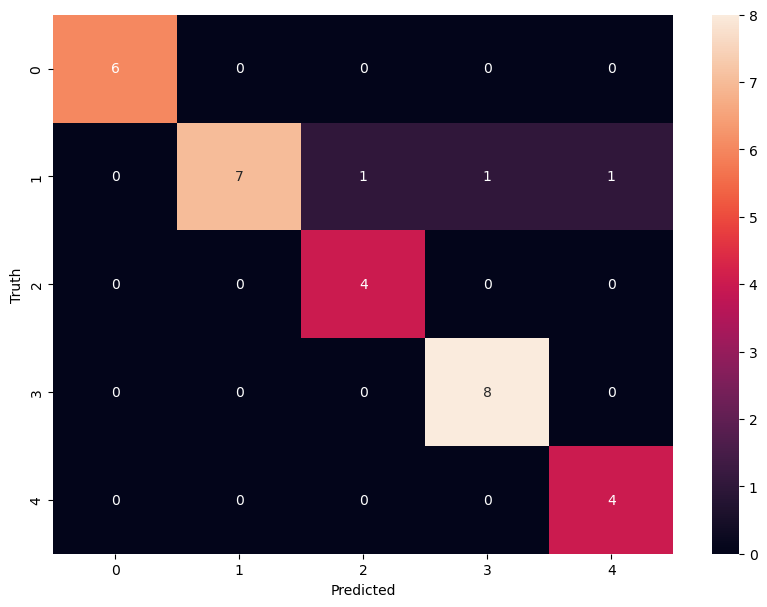

In [45]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [46]:
class_dict

{'Andrew_Ng': 0,
 'Elon_Mask': 1,
 'Fei-Fei_Li': 2,
 'Geoffrey_Hinton': 3,
 'Ilya_Sutskever': 4}

#### Save the model

In [47]:
joblib.dump(best_clf, 'saved_model.pk1')

['saved_model.pk1']

#### Saving the dictionary of person

In [48]:
with open('class_dictionary.json', 'w') as f:
    f.write(json.dumps(class_dict))